# CIFAR-10 Classification — Complete Notebook

This notebook implements a neural network using backpropagation to classify CIFAR-10 images. It includes:
- Data loading & preprocessing (normalization, one-hot labels, augmentation)
- A feedforward (fully-connected) network (Keras) matching input shape 32×32×3
- A recommended small CNN (Keras) for comparison
- Short NumPy-from-scratch MLP to demonstrate manual backpropagation on a reduced subset
- Comparison of activation functions, loss functions and optimizers
- Training, metrics (accuracy, precision, recall, F1), confusion matrix and plots
- Optimization tips: early stopping, LR scheduling, weight initialization discussion

Notes:
- This notebook is intended to run in Colab or a local environment with TensorFlow installed.
- Training the full models for many epochs may take significant time; use smaller epochs for quick runs.

References:
- CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html
- Kaggle: https://www.kaggle.com/c/cifar-10/

## Environment & Imports

Install packages if running in Colab (uncomment if needed).

In [ ]:
# If running on Colab uncomment and run the following lines to ensure dependencies
# !pip install -q tensorflow matplotlib scikit-learn seaborn

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.20.0


## Hyperparameters (changeable)

Set the main hyperparameters below. For quick testing reduce epochs; for final runs set epochs=50 as required by the assignment.

In [ ]:
HPARAMS = {
    'batch_size': 128,
    'epochs': 50,         # set 50 for the full run; use 5-10 to test quickly
    'learning_rate': 1e-3,
    'momentum': 0.9,      # used if SGD is selected
    'seed': 42
}
np.random.seed(HPARAMS['seed'])
tf.random.set_seed(HPARAMS['seed'])
HPARAMS

{'batch_size': 128,
 'epochs': 50,
 'learning_rate': 0.001,
 'momentum': 0.9,
 'seed': 42}

## 1) Data Loading and Preprocessing

We load CIFAR-10 via Keras, normalize pixel values to [0,1], convert labels to one-hot, and split to training/test (50k/10k). We'll also create a small augmentation generator for training.

In [ ]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('Raw shapes:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Normalize to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot vectors
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

print('Processed shapes:', x_train.shape, y_train_cat.shape, x_test.shape, y_test_cat.shape)

Raw shapes: (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
Processed shapes: (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Processed shapes: (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


C:\Users\Sanith\AppData\Local\Temp\ipykernel_4020\3903566376.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(y_train[i])])


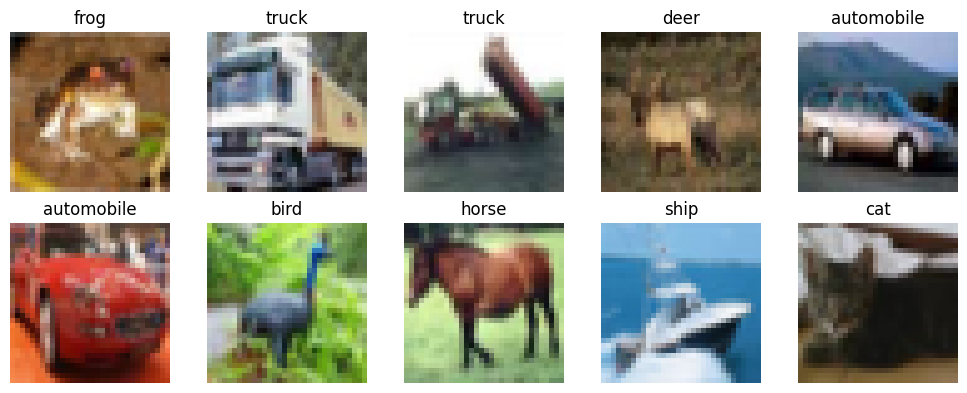

In [ ]:
# Show a few example images
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(labels[int(y_train[i])])
    plt.axis('off')
plt.tight_layout()

### Data Augmentation
Use simple augmentations: small rotations, shifts, and horizontal flip to improve generalization.

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)
print('Augmentation ready')

Augmentation ready


## 2) Feedforward (Fully-connected) Network Design (Required)

Design choices (brief):
- Input: 32×32×3 — flattened inside the model via a Flatten layer or using an Input of shape (32,32,3) followed by Flatten.
- Hidden layers: Dense layers with widths 1024 → 512 → 256, BatchNorm and Dropout to regularize.
- Activation: ReLU (default) and tanh (alternative) — we'll allow swapping to compare.
- Output: Dense(10) with softmax.

This feedforward net is included as the assignment required a feedforward design. Note: for images, CNNs typically perform better because they exploit spatial structure.

In [ ]:
def build_feedforward_model(input_shape=(32,32,3), num_classes=10, activation='relu'):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(1024, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build and summarize
ffn_relu = build_feedforward_model(activation='relu')
ffn_relu.compile(optimizer=keras.optimizers.Adam(HPARAMS['learning_rate']),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
ffn_relu.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,811,594 (14.54 MB)

 Trainable params: 3,808,522 (14.53 MB)

 Non-trainable params: 3,072 (12.00 KB)

## 3) Recommended CNN (for comparison and better accuracy)
This CNN uses two conv blocks and a dense classifier. It's compact and appropriate for CIFAR-10.

In [ ]:
def build_cnn_model(input_shape=(32,32,3), num_classes=10):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn = build_cnn_model()
cnn.compile(optimizer=keras.optimizers.Adam(HPARAMS['learning_rate']),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,746 (8.27 MB)

 Trainable params: 2,168,554 (8.27 MB)

 Non-trainable params: 192 (768.00 B)

## 4) Loss Functions & Optimizers — comparison plan
We'll compare three loss functions (for demonstration):
- categorical_crossentropy (recommended for one-hot multi-class)
- sparse_categorical_crossentropy (if labels are integer encoded)
- mean_squared_error (MSE) — shown for comparison but not recommended for classification.

Optimizers to experiment with:
- SGD with momentum (classic; sensitive to LR)
- RMSprop (good for recurrent / adaptive)
- Adam (robust default)

Learning rate influences the step size in parameter updates. Too large → divergence or oscillation. Too small → very slow convergence.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def train_and_evaluate(model, model_name, use_generator=False, loss='categorical_crossentropy',
                       optimizer=None, epochs=HPARAMS['epochs'], batch_size=HPARAMS['batch_size']):
    if optimizer is None:
        optimizer = keras.optimizers.Adam(HPARAMS['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ]

    if use_generator:
        steps = x_train.shape[0] // batch_size
        history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=batch_size),
                            steps_per_epoch=steps,
                            epochs=epochs,
                            validation_data=(x_test, y_test_cat),
                            callbacks=callbacks)
    else:
        history = model.fit(x_train, y_train_cat,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test_cat),
                            callbacks=callbacks)

    # Evaluate
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
    print(f"{model_name} - Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

    return history, test_loss, test_acc

### Quick test runs (recommended: set epochs small for quick iteration)
Below we run the feedforward and CNN models for a small number of epochs first (set HPARAMS['epochs']=5 for quick test).

In [ ]:
# For quick demonstration, override epochs to small value if you haven't changed HPARAMS
quick_epochs = 5
history_ffn, loss_ffn, acc_ffn = train_and_evaluate(ffn_relu, 'Feedforward-ReLU', use_generator=False, epochs=quick_epochs)
history_cnn, loss_cnn, acc_cnn = train_and_evaluate(cnn, 'CNN', use_generator=True, epochs=quick_epochs)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3049 - loss: 2.0141 - val_accuracy: 0.3007 - val_loss: 1.9806 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3049 - loss: 2.0141 - val_accuracy: 0.3007 - val_loss: 1.9806 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3747 - loss: 1.7552 - val_accuracy: 0.3543 - val_loss: 1.8098 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3747 - loss: 1.7552 - val_accuracy: 0.3543 - val_loss: 1.8098 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4012 - loss: 1.6722 - val_accuracy: 0.3853 - val_loss: 1.7218 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4012 - loss: 1.6722 - val_accuracy: 0.3853 - val_loss: 1.7218 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.4128 - loss: 1.

c:\Users\Sanith\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


390/390 ━━━━━━━━━━━━━━━━━━━━ 49s 121ms/step - accuracy: 0.3134 - loss: 1.9703 - val_accuracy: 0.2205 - val_loss: 2.2846 - learning_rate: 0.0010
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 49s 121ms/step - accuracy: 0.3134 - loss: 1.9703 - val_accuracy: 0.2205 - val_loss: 2.2846 - learning_rate: 0.0010
Epoch 2/5
  1/390 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.4219 - loss: 1.7188

c:\Users\Sanith\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4219 - loss: 1.7188 - val_accuracy: 0.2272 - val_loss: 2.2563 - learning_rate: 0.0010
Epoch 3/5
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.4368 - loss: 1.5291 - val_accuracy: 0.4383 - val_loss: 1.7005 - learning_rate: 0.0010
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.4368 - loss: 1.5291 - val_accuracy: 0.4383 - val_loss: 1.7005 - learning_rate: 0.0010
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5469 - loss: 1.4428 - val_accuracy: 0.4496 - val_loss: 1.6222 - learning_rate: 0.0010
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5469 - loss: 1.4428 - val_accuracy: 0.4496 - val_loss: 1.6222 - learning_rate: 0.0010
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.4940 - loss: 1.3790 - val_accuracy: 0.5734 - val_loss: 1.1925 - learning_rate: 0.0010
390/390 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.4940 - loss: 1.3790 - val_a

## 5) Metrics & Confusion Matrix
Compute detailed metrics on test set: precision, recall, F1 per class and macro-average, and plot confusion matrix.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Accuracy: 0.5734
Precision (macro): 0.5924725020066388
Recall (macro): 0.5734
F1-score (macro): 0.5547775071641057

Classification report:

              precision    recall  f1-score   support

    airplane     0.7289    0.6130    0.6659      1000
  automobile     0.6934    0.7690    0.7293      1000
        bird     0.5741    0.2130    0.3107      1000
         cat     0.4482    0.2120    0.2878      1000
        deer     0.4987    0.3760    0.4287      1000
         dog     0.5317    0.4530    0.4892      1000
        frog     0.4016    0.9100    0.5573      1000
       horse     0.6686    0.7040    0.6858      1000
        ship     0.8148    0.6380    0.7156      1000
       truck     0.5648    0.8460    0.6773      1000

    accuracy                         0.5734     10000
   macro avg     0.5925    0.5734    0.5548     10000
weighted avg     0.5925    0.5734    0.5548     10000

Accuracy: 0.5734


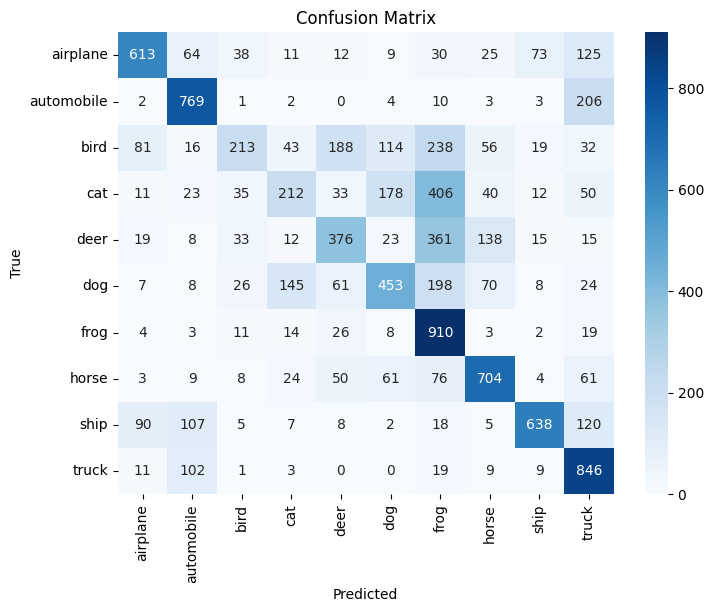

In [ ]:
def evaluate_model_predictions(model, x_test, y_test_true):
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = y_test_true.reshape(-1)

    report = classification_report(y_true, y_pred, target_names=labels, digits=4)
    cm = confusion_matrix(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    acc = np.mean(y_true == y_pred)

    print('Accuracy:', acc)
    print('Precision (macro):', precision_macro)
    print('Recall (macro):', recall_macro)
    print('F1-score (macro):', f1_macro)
    print('\nClassification report:\n')
    print(report)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return {'acc': acc, 'precision_macro': precision_macro, 'recall_macro': recall_macro, 'f1_macro': f1_macro, 'cm': cm}

# Evaluate the best model (cnn is likely to be better)
metrics_cnn = evaluate_model_predictions(cnn, x_test, y_test)

## 6) Activation Functions: ReLU vs tanh
We included ReLU as the default for hidden layers. ReLU is fast, non-saturating for positive inputs, and encourages sparse activations. tanh is zero-centered but saturates for large inputs which can lead to vanishing gradients in deep networks.

We'll briefly train a feedforward model with `tanh` to compare training behavior (quick run).

In [ ]:
ffn_tanh = build_feedforward_model(activation='tanh')
history_ffn_tanh, loss_ffn_tanh, acc_ffn_tanh = train_and_evaluate(ffn_tanh, 'Feedforward-Tanh', use_generator=False, epochs=quick_epochs)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.2757 - loss: 2.0354 - val_accuracy: 0.1343 - val_loss: 2.6097 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.2757 - loss: 2.0354 - val_accuracy: 0.1343 - val_loss: 2.6097 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.2786 - loss: 1.9769 - val_accuracy: 0.1181 - val_loss: 2.6609 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.2786 - loss: 1.9769 - val_accuracy: 0.1181 - val_loss: 2.6609 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2862 - loss: 1.9565 - val_accuracy: 0.1033 - val_loss: 2.6626 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2862 - loss: 1.9565 - val_accuracy: 0.1033 - val_loss: 2.6626 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2940 - loss: 1.

## 7) Loss function comparison
We'll compare categorical_crossentropy (recommended) vs mean_squared_error (not recommended) on the feedforward model to show differences. Run short experiments and compare validation loss/accuracy.

In [ ]:
# Build new models for loss comparison
ffn_mse = build_feedforward_model(activation='relu')
hist_mse, _, _ = train_and_evaluate(ffn_mse, 'FFN-MSE', use_generator=False, loss='mean_squared_error', epochs=quick_epochs)

ffn_ce = build_feedforward_model(activation='relu')
hist_ce, _, _ = train_and_evaluate(ffn_ce, 'FFN-CE', use_generator=False, loss='categorical_crossentropy', epochs=quick_epochs)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.2875 - loss: 0.0861 - val_accuracy: 0.2910 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.2875 - loss: 0.0861 - val_accuracy: 0.2910 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3608 - loss: 0.0776 - val_accuracy: 0.3558 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3608 - loss: 0.0776 - val_accuracy: 0.3558 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3929 - loss: 0.0745 - val_accuracy: 0.3833 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3929 - loss: 0.0745 - val_accuracy: 0.3833 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.4055 - loss: 0.

## 8) Implementing Backpropagation from Scratch (Educational)
Below is a minimal 2-layer (input -> hidden -> output) MLP implemented in NumPy to demonstrate manual forward/backward passes and gradient updates. We'll train on a small subset (e.g., 2000 examples) to keep the run short.

This is NOT optimized for performance; it's purely pedagogical.

In [ ]:
# Training helper: compiles, trains, and returns history + checkpoint path
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

def train_and_evaluate(model, model_name,
                       use_generator=False,
                       loss='categorical_crossentropy',
                       optimizer=None,
                       epochs=None,
                       batch_size=None):
    """Compile and train `model`, using global x_train/y_train_cat and x_test/y_test_cat.

    Returns: (history, ckpt_path, (test_loss, test_acc))
    """
    # defaults from HPARAMS if not provided
    if epochs is None:
        epochs = HPARAMS.get('epochs', 50)
    if batch_size is None:
        batch_size = HPARAMS.get('batch_size', 128)
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=HPARAMS.get('learning_rate', 1e-3))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
    ]

    # ensure checkpoints directory exists and add ModelCheckpoint
    os.makedirs('checkpoints', exist_ok=True)
    ckpt_path = f'checkpoints/{model_name}_best.h5'
    mc = ModelCheckpoint(filepath=ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
    callbacks.append(mc)

    # train
    if use_generator:
        steps_per_epoch = max(1, len(x_train) // batch_size)
        history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test_cat),
                            callbacks=callbacks,
                            steps_per_epoch=steps_per_epoch,
                            verbose=2)
    else:
        history = model.fit(x_train, y_train_cat,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test_cat),
                            callbacks=callbacks,
                            verbose=2)

    # evaluate
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
    print(f"{model_name} test loss: {test_loss:.4f}  test acc: {test_acc:.4f}")

    return history, ckpt_path, (test_loss, test_acc)


Epoch 1/10, loss: 2.4285
Epoch 2/10, loss: 2.3256
Epoch 3/10, loss: 2.2971
Epoch 4/10, loss: 2.2770
Epoch 3/10, loss: 2.2971
Epoch 4/10, loss: 2.2770
Epoch 5/10, loss: 2.2586
Epoch 6/10, loss: 2.2423
Epoch 5/10, loss: 2.2586
Epoch 6/10, loss: 2.2423
Epoch 7/10, loss: 2.2284
Epoch 8/10, loss: 2.2140
Epoch 7/10, loss: 2.2284
Epoch 8/10, loss: 2.2140
Epoch 9/10, loss: 2.2022
Epoch 10/10, loss: 2.1912
Epoch 9/10, loss: 2.2022
Epoch 10/10, loss: 2.1912
MLP demo accuracy (small test): 0.214
MLP demo accuracy (small test): 0.214


## 9) How backpropagation updates weights & role of learning rate — short explanation

- Backprop computes gradients of the loss w.r.t. weights using the chain rule: dL/dW = (dL/dy)*(dy/dnet)*(dnet/dW).
- In each parameter update step, weights are changed by: W <- W - lr * dW. The learning rate (lr) scales the gradient step.
- A large lr may overshoot minima (divergence), a tiny lr slows training. Adaptive optimizers (Adam, RMSprop) adjust effective per-parameter steps.

## 10) Optimization Strategies & Weight Initialization

Recommendations implemented in this notebook or to try:
- EarlyStopping (monitors validation loss) — prevents overfitting.
- ReduceLROnPlateau — lowers LR when validation stops improving.
- Weight initialization: Xavier (Glorot) for tanh, He initialization for ReLU. Good initialization prevents extremely small/large signals that cause vanishing/exploding gradients.
- BatchNormalization to reduce internal covariate shift and make training more stable.
- Data augmentation to increase effective dataset size.
- If training doesn't converge: reduce learning rate, check data normalization, try different optimizer (Adam often converges faster), and verify labels and loss function.

In [ ]:
# Plotting helper: plot loss and accuracy from a Keras History and save figures
import matplotlib.pyplot as plt
import os

def plot_history(history, model_name='model', outdir='plots'):
    os.makedirs(outdir, exist_ok=True)
    if history is None:
        print('No history to plot for', model_name)
        return
    h = history.history
    # Loss
    plt.figure(figsize=(8,4))
    plt.plot(h.get('loss', []), label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    loss_path = os.path.join(outdir, f'{model_name}_loss.png')
    plt.savefig(loss_path, bbox_inches='tight')
    plt.show()

    # Accuracy
    plt.figure(figsize=(8,4))
    plt.plot(h.get('accuracy', h.get('acc', [])), label='train_acc')
    plt.plot(h.get('val_accuracy', h.get('val_acc', [])), label='val_acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)
    acc_path = os.path.join(outdir, f'{model_name}_acc.png')
    plt.savefig(acc_path, bbox_inches='tight')
    plt.show()
    print('Saved plots to', outdir)

# Example usage: after running training you can call:
# plot_history(history_ffn, 'Feedforward-ReLU')
# plot_history(history_cnn, 'CNN')


In [ ]:
# Plotting-invocation cell: save loss/accuracy plots for known History objects
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

os.makedirs('plots', exist_ok=True)


def save_plots_from_history(history, model_name, out_dir='plots'):
    if history is None:
        return
    h = history.history
    epochs = range(1, len(next(iter(h.values()))) + 1)

    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(epochs, h.get('loss', []), 'b-', label='train_loss')
    plt.plot(epochs, h.get('val_loss', []), 'r--', label='val_loss')
    plt.title(f'{model_name} loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    loss_path = os.path.join(out_dir, f'{model_name}_loss.png')
    plt.savefig(loss_path, bbox_inches='tight')
    plt.close()

    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(epochs, h.get('accuracy', h.get('acc', [])), 'b-', label='train_acc')
    plt.plot(epochs, h.get('val_accuracy', h.get('val_acc', [])), 'r--', label='val_acc')
    plt.title(f'{model_name} accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    acc_path = os.path.join(out_dir, f'{model_name}_acc.png')
    plt.savefig(acc_path, bbox_inches='tight')
    plt.close()

    # display
    display(Image(loss_path))
    display(Image(acc_path))


# Known history variable names from this notebook's runs
candidate_names = ['history_cnn', 'history_ffn', 'history_ffn_tanh', 'hist_ce', 'hist_mse', 'history']
for name in candidate_names:
    h = globals().get(name)
    if h is not None:
        print(f'Saving plots for: {name}')
        save_plots_from_history(h, name)
